In [1]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import os
import random

In [2]:
data_connect_size = 128

def y_encode(data):
    encode_data = []
    
    #is negative number
    
    for i in data:
        if i < 0:
            tmp = [0, 0, 1]
        elif i == 0:
            tmp = [0, 1, 0]
        else:
            tmp = [1, 0, 0]
        
        
        encode_data.append(tmp)
            
    return np.array(encode_data)

def predict_decode(data):
    index = np.array(data).argmax()
    
    if index == 0:
        return 1
    elif index == 1:
        return 0
    
    return -1

def data_decode(data):
    min_number = np.average(data)
    decode_data = []
    
    for i in data:
        tmp = i - min_number
        
        if tmp > 0:
            decode_data.append(tmp)
        else:
            decode_data.append(tmp * -1)
            
    return np.array(decode_data)

def lstm_boolean_data_encode(dataset):
    dataset = np.array(dataset, copy=True)
    new_dataset = []
    data_connect_size = 128
    
    for index, data in enumerate(dataset):
        connect_index = index - data_connect_size
        connect_index = 0 if connect_index < 0 else connect_index
        connect_dataset = np.array(dataset[connect_index + 1: index + 1], copy=True)
        
        now_connect_dataset_size = len(connect_dataset)
        
        diff_size = now_connect_dataset_size - data_connect_size
        
        if diff_size < 0:
            update_dataset = np.zeros(data_connect_size)
            update_dataset[diff_size * -1:] = connect_dataset[:]
            
            connect_dataset = update_dataset
        
        new_dataset.append(connect_dataset.reshape(data_connect_size, 1))
        
    return np.array(new_dataset)

In [3]:
max_length = 0

In [4]:
y_rate, y_data = [[None] * 2] * 2

for i in range(2):
    file_path = os.sep.join([os.path.expanduser("~lewis"), "wave_test", "dataset", str(i + 1) + ".wav"]);
    y_rate[i], y_data[i] = wavfile.read(file_path)
    
    if y_data[i].shape[0] > max_length:
        max_length = y_data[i].shape[0]

/usr/local/lib/python3.4/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [5]:
x_rate, x_data = [[None] * 4] * 2
test_x_data = [None] * 4

for i in range(4):
    file_path = os.sep.join([os.path.expanduser("~lewis"), "wave_test", "dataset", "1", str(i + 1) + ".wav"]);
    x_rate[i], x_data[i] = wavfile.read(file_path)
    
    if x_data[i].shape[0] > max_length:
        max_length = x_data[i].shape[0]

/usr/local/lib/python3.4/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [6]:
# y format

data_format = np.zeros([max_length])

for i, data in enumerate(y_data):
    tmp_format = np.array(data_format, copy=True)
    tmp_boolean_format = np.array(data_format, copy=True)
    # 轉為單聲到，且切齊最常時間檔案
    tmp_format[:len(y_data[i])] = [i[0] for i in y_data[i]]
    
    y_data[i] = y_encode(tmp_format)
    
y_data = np.array(y_data)

In [7]:
# x format

data_format = np.zeros([max_length])

for i, data in enumerate(x_data):
    tmp_format = np.array(data_format, copy=True)
    tmp_boolean_format = np.array(data_format, copy=True)
    # 轉為單聲到，且切齊最常時間檔案
    tmp_format[:len(x_data[i])] = [i[0] for i in x_data[i]]
    
    test_x_data[i] = np.array(tmp_format, copy=True)
    
    x_data[i] = lstm_boolean_data_encode(tmp_format)
    
x_data = np.array(x_data)

In [8]:
y_data.shape

(2, 28814, 3)

In [9]:
x_data.shape

(4, 28814, 128, 1)

In [10]:
X = x_data

In [11]:
Y = np.array([y_data[0]] * 4)

In [12]:
X.shape

(4, 28814, 128, 1)

In [13]:
Y.shape

(4, 28814, 3)

In [14]:
max_length

28814

In [15]:
data_connect_size

128

In [16]:
import tflearn

In [17]:
net = tflearn.input_data(shape=[None, 128, 1])
net = tflearn.lstm(net, 128, return_seq=True)
net = tflearn.lstm(net, 128)
net = tflearn.fully_connected(net, 3, activation='softmax')
net = tflearn.regression(net, optimizer='adam',
                         loss='categorical_crossentropy', name="output1")
model = tflearn.DNN(net, tensorboard_verbose=2)

In [18]:
#model.load("test_wave_mod")

In [19]:
for i in range(40):
    file_id = i % 4

    fit_x = X[file_id]
    fit_y = Y[file_id]

    model.fit(fit_x, fit_y, n_epoch=2, validation_set=0.1, show_metric=True,
          snapshot_step=100)

Training Step: 32479  | total loss: 0.50652 | time: 38.508s
| Adam | epoch: 080 | loss: 0.50652 - acc: 0.6876 -- iter: 25920/25932
Training Step: 32480  | total loss: 0.50814 | time: 39.871s
| Adam | epoch: 080 | loss: 0.50814 - acc: 0.6751 | val_loss: 0.51720 - val_acc: 0.6530 -- iter: 25932/25932
--


In [20]:
model.save("wave_boolean_128_lstm")

INFO:tensorflow:/home/lewis/wave_test/wave_boolean_128_lstm is not in all_model_checkpoint_paths. Manually adding it.
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'list' object has no attribute 'name'


In [21]:
predict = model.predict(X[0])

In [22]:
values = []

for i in predict:
    values.append(predict_decode(i))
    
values = np.array(values)

np.save("wave_boolean_lstm.npy", values)

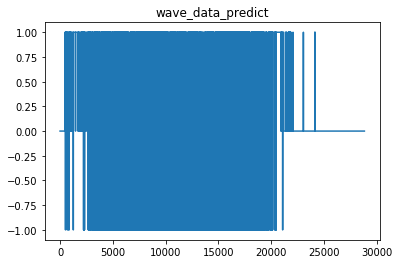

In [23]:
plt.figure(1)
plt.title('wave_data_predict')
plt.plot(values)
plt.show()

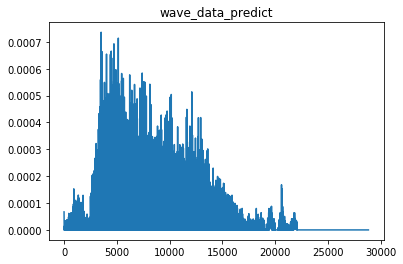

In [14]:
test = np.load("test_wave.npy")

plt.figure(1)
plt.title('wave_data_predict')
plt.plot(test)
plt.show()

In [26]:
boolean_value = np.load("wave_boolean_lstm.npy")

test_build = test * boolean_value
test_build = np.array(test_build)
test_build = test_build + test_x_data[3].reshape(max_length)
test_build

array([ 0.00897217,  0.0088501 ,  0.00869751, ...,  0.        ,
        0.        ,  0.        ])

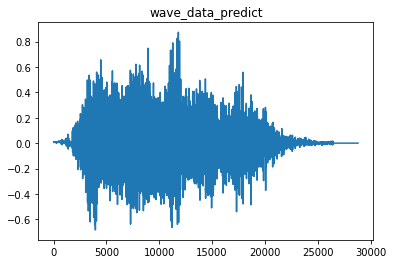

In [27]:
plt.figure(1)
plt.title('wave_data_predict')
plt.plot(test_build)
plt.show()

In [28]:
test_build_output = []

for i in test_build:
    a = i * 1000
    test_build_output.append([a, a])


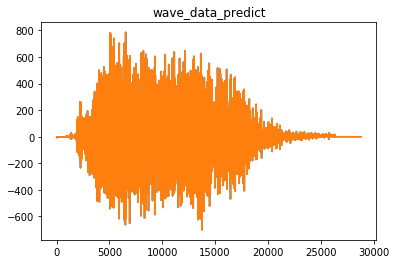

In [24]:
plt.figure(1)
plt.title('wave_data_predict')
plt.plot(test_build_output)
plt.show()

In [25]:
wavfile.write("test.wav", 44100, np.array(test_build_output, dtype=np.float32))